In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print(tf.VERSION)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


Loading the data of the [SLAC dataset](http://jmir.sourceforge.net/Codaich.html), with 250 MIDI files. The dataset is equally balanced over the classes.

The vectors are computed using [midi2vec](https://github.com/midi-ld/midi2vec).

The dataset provides 2 kind of classes (genres and subgenres), respectively of 5 and 10 elements:

- Blues
    - Modern Blues
    - Traditional Blues
- Classical
    - Baroque
    - Romantic
- Jazz
    - Bop
    - Swing
- Rap
    - Hardcore Rap
    - Pop Rap
- Rock
    - Alternative Rock
    - Metal

In [2]:
data = np.loadtxt('./dataset-slac/vectors.txt')
genres = np.loadtxt('./dataset-slac/genre.txt', dtype=np.str, delimiter=',')
subgenres = np.loadtxt('./dataset-slac/subgenre.txt', dtype=np.str, delimiter=',')

The labels are represented with the 1-hot encoding

In [3]:
encoder = LabelBinarizer()
def onehot_labels(labels):
    return encoder.fit_transform(labels)
    
def onehot2str(onehot):
    return encoder.inverse_transform(np.array([onehot]))[0]

In [4]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # one hot to index
    y_true = [np.where(r==1)[0][0] for r in y_true]
    # y_pred are already indexes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.unique(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    classes = [c[0:10] if len(c) > 10 else c for c in classes]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Experiment 1: Genres 

In [5]:
labels_1hot = onehot_labels(genres)
    
onehot2str(labels_1hot[0])

'Classical'

In [6]:
data.shape

(250, 100)

In [7]:
labels_1hot.shape

(250, 5)

In [8]:
num_input = data.shape[1]
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 5)

We use a Neural Network with 3 dense layers, trained with the Adam Optimizer.

In [9]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

The network is evaluated with 10-fold cross-validation. The final score is the average of the results.

In [11]:
random_state = 2111
scores = cross_val_score(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
225/225 [==============================] - 0s 716us/sample - loss: 0.4794 - acc: 0.7849
Epoch 2/100
225/225 [==============================] - 0s 68us/sample - loss: 0.2251 - acc: 0.9120
Epoch 3/100
225/225 [==============================] - 0s 56us/sample - loss: 0.1100 - acc: 0.9591
Epoch 4/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0556 - acc: 0.9787
Epoch 5/100
225/225 [==============================] - 0s 66us/sample - loss: 0.0230 - acc: 0.9947
Epoch 6/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0107 - acc: 0.9991
Epoch 7/100
225/225 [==============================] - 0s 77us/sample - loss: 0.0079 - acc: 0.9991
Epoch 8/100
225/225 [==============================] - 0s 84us/sample - loss: 0.0046 - acc: 0.9991
Epoch 9/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0175 - 

225/225 [==============================] - 0s 60us/sample - loss: 2.6586e-05 - acc: 1.0000
Epoch 75/100
225/225 [==============================] - 0s 83us/sample - loss: 2.5845e-05 - acc: 1.0000
Epoch 76/100
225/225 [==============================] - 0s 54us/sample - loss: 2.5212e-05 - acc: 1.0000
Epoch 77/100
225/225 [==============================] - 0s 53us/sample - loss: 2.4670e-05 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 55us/sample - loss: 2.4126e-05 - acc: 1.0000
Epoch 79/100
225/225 [==============================] - 0s 61us/sample - loss: 2.3577e-05 - acc: 1.0000
Epoch 80/100
225/225 [==============================] - 0s 63us/sample - loss: 2.3153e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 65us/sample - loss: 2.2526e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 60us/sample - loss: 2.2180e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 68us/sample - loss

225/225 [==============================] - 0s 62us/sample - loss: 5.0158e-05 - acc: 1.0000
Epoch 53/100
225/225 [==============================] - 0s 61us/sample - loss: 4.8420e-05 - acc: 1.0000
Epoch 54/100
225/225 [==============================] - 0s 66us/sample - loss: 4.6550e-05 - acc: 1.0000
Epoch 55/100
225/225 [==============================] - 0s 61us/sample - loss: 4.5341e-05 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 57us/sample - loss: 4.3511e-05 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 59us/sample - loss: 4.1806e-05 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 60us/sample - loss: 4.0898e-05 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 52us/sample - loss: 3.9348e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 51us/sample - loss: 3.7942e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 59us/sample - loss

225/225 [==============================] - 0s 56us/sample - loss: 1.2244e-04 - acc: 1.0000
Epoch 31/100
225/225 [==============================] - 0s 56us/sample - loss: 1.1722e-04 - acc: 1.0000
Epoch 32/100
225/225 [==============================] - 0s 61us/sample - loss: 1.1021e-04 - acc: 1.0000
Epoch 33/100
225/225 [==============================] - 0s 66us/sample - loss: 1.0853e-04 - acc: 1.0000
Epoch 34/100
225/225 [==============================] - 0s 61us/sample - loss: 1.0030e-04 - acc: 1.0000
Epoch 35/100
225/225 [==============================] - 0s 58us/sample - loss: 9.1591e-05 - acc: 1.0000
Epoch 36/100
225/225 [==============================] - 0s 59us/sample - loss: 8.4065e-05 - acc: 1.0000
Epoch 37/100
225/225 [==============================] - 0s 61us/sample - loss: 7.8204e-05 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 56us/sample - loss: 7.3722e-05 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 50us/sample - loss

225/225 [==============================] - 0s 50us/sample - loss: 0.0093 - acc: 0.9991
Epoch 9/100
225/225 [==============================] - 0s 49us/sample - loss: 0.0076 - acc: 0.9973
Epoch 10/100
225/225 [==============================] - 0s 52us/sample - loss: 0.0044 - acc: 0.9991
Epoch 11/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0062 - acc: 0.9982
Epoch 12/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0022 - acc: 1.0000
Epoch 13/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0027 - acc: 1.0000
Epoch 14/100
225/225 [==============================] - 0s 72us/sample - loss: 0.0011 - acc: 1.0000
Epoch 15/100
225/225 [==============================] - 0s 63us/sample - loss: 0.0014 - acc: 0.9991
Epoch 16/100
225/225 [==============================] - 0s 52us/sample - loss: 7.8418e-04 - acc: 1.0000
Epoch 17/100
225/225 [==============================] - 0s 57us/sample - loss: 4.8773e-04 - acc: 1.0000
Epoch 

225/225 [==============================] - 0s 72us/sample - loss: 1.1678e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 73us/sample - loss: 1.1387e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 95us/sample - loss: 1.1116e-05 - acc: 1.0000
Epoch 90/100
225/225 [==============================] - 0s 78us/sample - loss: 1.0853e-05 - acc: 1.0000
Epoch 91/100
225/225 [==============================] - 0s 66us/sample - loss: 1.0627e-05 - acc: 1.0000
Epoch 92/100
225/225 [==============================] - 0s 60us/sample - loss: 1.0401e-05 - acc: 1.0000
Epoch 93/100
225/225 [==============================] - 0s 95us/sample - loss: 1.0132e-05 - acc: 1.0000
Epoch 94/100
225/225 [==============================] - 0s 68us/sample - loss: 9.8833e-06 - acc: 1.0000
Epoch 95/100
225/225 [==============================] - 0s 74us/sample - loss: 9.6815e-06 - acc: 1.0000
Epoch 96/100
225/225 [==============================] - 0s 88us/sample - loss

225/225 [==============================] - 0s 87us/sample - loss: 2.3171e-05 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 82us/sample - loss: 2.2623e-05 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 61us/sample - loss: 2.2046e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 59us/sample - loss: 2.1460e-05 - acc: 1.0000
Epoch 69/100
225/225 [==============================] - 0s 65us/sample - loss: 2.0868e-05 - acc: 1.0000
Epoch 70/100
225/225 [==============================] - 0s 65us/sample - loss: 2.0513e-05 - acc: 1.0000
Epoch 71/100
225/225 [==============================] - 0s 65us/sample - loss: 2.0018e-05 - acc: 1.0000
Epoch 72/100
225/225 [==============================] - 0s 62us/sample - loss: 1.9582e-05 - acc: 1.0000
Epoch 73/100
225/225 [==============================] - 0s 67us/sample - loss: 1.9115e-05 - acc: 1.0000
Epoch 74/100
225/225 [==============================] - 0s 56us/sample - loss

225/225 [==============================] - 0s 82us/sample - loss: 5.8183e-05 - acc: 1.0000
Epoch 44/100
225/225 [==============================] - 0s 63us/sample - loss: 5.6186e-05 - acc: 1.0000
Epoch 45/100
225/225 [==============================] - 0s 81us/sample - loss: 5.3777e-05 - acc: 1.0000
Epoch 46/100
225/225 [==============================] - 0s 71us/sample - loss: 5.0704e-05 - acc: 1.0000
Epoch 47/100
225/225 [==============================] - 0s 96us/sample - loss: 4.8295e-05 - acc: 1.0000
Epoch 48/100
225/225 [==============================] - 0s 76us/sample - loss: 4.6436e-05 - acc: 1.0000
Epoch 49/100
225/225 [==============================] - 0s 69us/sample - loss: 4.4939e-05 - acc: 1.0000
Epoch 50/100
225/225 [==============================] - 0s 68us/sample - loss: 4.3168e-05 - acc: 1.0000
Epoch 51/100
225/225 [==============================] - 0s 66us/sample - loss: 4.1655e-05 - acc: 1.0000
Epoch 52/100
225/225 [==============================] - 0s 74us/sample - loss

225/225 [==============================] - 0s 54us/sample - loss: 2.7224e-04 - acc: 1.0000
Epoch 22/100
225/225 [==============================] - 0s 57us/sample - loss: 2.1311e-04 - acc: 1.0000
Epoch 23/100
225/225 [==============================] - 0s 54us/sample - loss: 1.9513e-04 - acc: 1.0000
Epoch 24/100
225/225 [==============================] - 0s 53us/sample - loss: 1.7516e-04 - acc: 1.0000
Epoch 25/100
225/225 [==============================] - 0s 55us/sample - loss: 1.5940e-04 - acc: 1.0000
Epoch 26/100
225/225 [==============================] - 0s 56us/sample - loss: 1.4667e-04 - acc: 1.0000
Epoch 27/100
225/225 [==============================] - 0s 58us/sample - loss: 1.3243e-04 - acc: 1.0000
Epoch 28/100
225/225 [==============================] - 0s 60us/sample - loss: 1.2374e-04 - acc: 1.0000
Epoch 29/100
225/225 [==============================] - 0s 64us/sample - loss: 1.1671e-04 - acc: 1.0000
Epoch 30/100
225/225 [==============================] - 0s 58us/sample - loss

225/225 [==============================] - 0s 60us/sample - loss: 1.4026e-05 - acc: 1.0000
Epoch 100/100
25/25 [==============================] - 0s 4ms/sample - loss: 0.9637 - acc: 0.8640
Epoch 1/100
225/225 [==============================] - 0s 913us/sample - loss: 0.5296 - acc: 0.7476
Epoch 2/100
225/225 [==============================] - 0s 60us/sample - loss: 0.2697 - acc: 0.9120
Epoch 3/100
225/225 [==============================] - 0s 56us/sample - loss: 0.1364 - acc: 0.9476
Epoch 4/100
225/225 [==============================] - 0s 52us/sample - loss: 0.0717 - acc: 0.9751
Epoch 5/100
225/225 [==============================] - 0s 58us/sample - loss: 0.0424 - acc: 0.9867
Epoch 6/100
225/225 [==============================] - 0s 53us/sample - loss: 0.0251 - acc: 0.9929
Epoch 7/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0129 - acc: 0.9973
Epoch 8/100
225/225 [==============================] - 0s 57us/sample - loss: 0.0059 - acc: 0.9991
Epoch 9/100
225/22

225/225 [==============================] - 0s 61us/sample - loss: 2.3482e-05 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 64us/sample - loss: 2.2883e-05 - acc: 1.0000
Epoch 79/100
225/225 [==============================] - 0s 62us/sample - loss: 2.2189e-05 - acc: 1.0000
Epoch 80/100
225/225 [==============================] - 0s 57us/sample - loss: 2.1400e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 57us/sample - loss: 2.0752e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 58us/sample - loss: 2.0298e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 60us/sample - loss: 1.9767e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 57us/sample - loss: 1.9198e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 54us/sample - loss: 1.8896e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 61us/sample - loss

225/225 [==============================] - 0s 56us/sample - loss: 2.2533e-05 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 61us/sample - loss: 2.1910e-05 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 62us/sample - loss: 2.1292e-05 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 56us/sample - loss: 2.0483e-05 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 61us/sample - loss: 1.9821e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 55us/sample - loss: 1.9195e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 56us/sample - loss: 1.8483e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 54us/sample - loss: 1.8024e-05 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 53us/sample - loss: 1.7660e-05 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 59us/sample - loss

225/225 [==============================] - 0s 65us/sample - loss: 9.1593e-05 - acc: 1.0000
Epoch 34/100
225/225 [==============================] - 0s 67us/sample - loss: 8.6835e-05 - acc: 1.0000
Epoch 35/100
225/225 [==============================] - 0s 62us/sample - loss: 8.2725e-05 - acc: 1.0000
Epoch 36/100
225/225 [==============================] - 0s 63us/sample - loss: 7.8632e-05 - acc: 1.0000
Epoch 37/100
225/225 [==============================] - 0s 58us/sample - loss: 7.4695e-05 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 57us/sample - loss: 7.1546e-05 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 58us/sample - loss: 6.8243e-05 - acc: 1.0000
Epoch 40/100
225/225 [==============================] - 0s 58us/sample - loss: 6.5486e-05 - acc: 1.0000
Epoch 41/100
225/225 [==============================] - 0s 55us/sample - loss: 6.2951e-05 - acc: 1.0000
Epoch 42/100
225/225 [==============================] - 0s 59us/sample - loss

array([0.90399992, 0.94399995, 0.92000002, 0.97600001, 0.95999998,
       0.88799995, 0.86400002, 0.91199994, 0.97600007, 0.84800005])

In [12]:
np.mean(scores)

0.9191999912261963

In [13]:
predicted = cross_val_predict(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

Epoch 1/100
225/225 [==============================] - 0s 1ms/sample - loss: 0.4922 - acc: 0.7813
Epoch 2/100
225/225 [==============================] - 0s 54us/sample - loss: 0.2381 - acc: 0.9173
Epoch 3/100
225/225 [==============================] - 0s 56us/sample - loss: 0.1213 - acc: 0.9556
Epoch 4/100
225/225 [==============================] - 0s 51us/sample - loss: 0.0681 - acc: 0.9813
Epoch 5/100
225/225 [==============================] - 0s 55us/sample - loss: 0.0535 - acc: 0.9813
Epoch 6/100
225/225 [==============================] - 0s 60us/sample - loss: 0.0333 - acc: 0.9884
Epoch 7/100
225/225 [==============================] - 0s 67us/sample - loss: 0.0157 - acc: 0.9964
Epoch 8/100
225/225 [==============================] - 0s 54us/sample - loss: 0.0066 - acc: 0.9991
Epoch 9/100
225/225 [==============================] - 0s 57us/sample - loss: 0.0054 - acc: 0.9982
Epoch 10/100
225/225 [==============================] - 0s 55us/sample - loss: 0.0031 - acc: 0.9991
Epoch 11/1

225/225 [==============================] - 0s 59us/sample - loss: 2.8295e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 59us/sample - loss: 2.7759e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 57us/sample - loss: 2.7243e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 59us/sample - loss: 2.6751e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 57us/sample - loss: 2.6193e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 54us/sample - loss: 2.5573e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 57us/sample - loss: 2.5162e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 65us/sample - loss: 2.4677e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 58us/sample - loss: 2.4072e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 60us/sample - loss

225/225 [==============================] - 0s 66us/sample - loss: 3.3625e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 69us/sample - loss: 3.2851e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 71us/sample - loss: 3.1724e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 64us/sample - loss: 3.1135e-05 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 66us/sample - loss: 3.0244e-05 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 75us/sample - loss: 2.9331e-05 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 65us/sample - loss: 2.9538e-05 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 67us/sample - loss: 2.9347e-05 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 66us/sample - loss: 2.7984e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 70us/sample - loss

225/225 [==============================] - 0s 72us/sample - loss: 1.7111e-04 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 71us/sample - loss: 1.5477e-04 - acc: 1.0000
Epoch 40/100
225/225 [==============================] - 0s 73us/sample - loss: 1.4389e-04 - acc: 1.0000
Epoch 41/100
225/225 [==============================] - 0s 58us/sample - loss: 1.3617e-04 - acc: 1.0000
Epoch 42/100
225/225 [==============================] - 0s 61us/sample - loss: 1.2812e-04 - acc: 1.0000
Epoch 43/100
225/225 [==============================] - 0s 74us/sample - loss: 1.2575e-04 - acc: 1.0000
Epoch 44/100
225/225 [==============================] - 0s 66us/sample - loss: 1.1604e-04 - acc: 1.0000
Epoch 45/100
225/225 [==============================] - 0s 72us/sample - loss: 1.0943e-04 - acc: 1.0000
Epoch 46/100
225/225 [==============================] - 0s 71us/sample - loss: 1.0512e-04 - acc: 1.0000
Epoch 47/100
225/225 [==============================] - 0s 67us/sample - loss

225/225 [==============================] - 0s 65us/sample - loss: 8.7360e-04 - acc: 1.0000
Epoch 18/100
225/225 [==============================] - 0s 63us/sample - loss: 6.8503e-04 - acc: 1.0000
Epoch 19/100
225/225 [==============================] - 0s 65us/sample - loss: 7.1346e-04 - acc: 1.0000
Epoch 20/100
225/225 [==============================] - 0s 66us/sample - loss: 5.1078e-04 - acc: 1.0000
Epoch 21/100
225/225 [==============================] - 0s 66us/sample - loss: 4.2743e-04 - acc: 1.0000
Epoch 22/100
225/225 [==============================] - 0s 64us/sample - loss: 3.9539e-04 - acc: 1.0000
Epoch 23/100
225/225 [==============================] - 0s 67us/sample - loss: 3.4299e-04 - acc: 1.0000
Epoch 24/100
225/225 [==============================] - 0s 62us/sample - loss: 4.0614e-04 - acc: 1.0000
Epoch 25/100
225/225 [==============================] - 0s 64us/sample - loss: 3.2133e-04 - acc: 1.0000
Epoch 26/100
225/225 [==============================] - 0s 62us/sample - loss

225/225 [==============================] - 0s 57us/sample - loss: 1.7325e-05 - acc: 1.0000
Epoch 96/100
225/225 [==============================] - 0s 58us/sample - loss: 1.7002e-05 - acc: 1.0000
Epoch 97/100
225/225 [==============================] - 0s 58us/sample - loss: 1.6679e-05 - acc: 1.0000
Epoch 98/100
225/225 [==============================] - 0s 56us/sample - loss: 1.6357e-05 - acc: 1.0000
Epoch 99/100
225/225 [==============================] - 0s 63us/sample - loss: 1.6097e-05 - acc: 1.0000
Epoch 100/100
225/225 [==============================] - 0s 63us/sample - loss: 1.5799e-05 - acc: 1.0000
Epoch 1/100
225/225 [==============================] - 0s 1ms/sample - loss: 0.5160 - acc: 0.7484
Epoch 2/100
225/225 [==============================] - 0s 58us/sample - loss: 0.2592 - acc: 0.9022
Epoch 3/100
225/225 [==============================] - 0s 61us/sample - loss: 0.1374 - acc: 0.9458
Epoch 4/100
225/225 [==============================] - 0s 59us/sample - loss: 0.0719 - acc: 

225/225 [==============================] - 0s 66us/sample - loss: 2.2186e-05 - acc: 1.0000
Epoch 75/100
225/225 [==============================] - 0s 60us/sample - loss: 2.1462e-05 - acc: 1.0000
Epoch 76/100
225/225 [==============================] - 0s 59us/sample - loss: 2.0788e-05 - acc: 1.0000
Epoch 77/100
225/225 [==============================] - 0s 61us/sample - loss: 2.0018e-05 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 60us/sample - loss: 2.0256e-05 - acc: 1.0000
Epoch 79/100
225/225 [==============================] - 0s 60us/sample - loss: 2.0038e-05 - acc: 1.0000
Epoch 80/100
225/225 [==============================] - 0s 65us/sample - loss: 1.8973e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 59us/sample - loss: 1.8272e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 61us/sample - loss: 1.7588e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 61us/sample - loss

225/225 [==============================] - 0s 61us/sample - loss: 5.8237e-05 - acc: 1.0000
Epoch 54/100
225/225 [==============================] - 0s 63us/sample - loss: 5.6168e-05 - acc: 1.0000
Epoch 55/100
225/225 [==============================] - 0s 65us/sample - loss: 5.4308e-05 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 65us/sample - loss: 5.3112e-05 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 64us/sample - loss: 5.0528e-05 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 65us/sample - loss: 4.9365e-05 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 60us/sample - loss: 4.7693e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 61us/sample - loss: 4.6364e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 61us/sample - loss: 4.5414e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 63us/sample - loss

225/225 [==============================] - 0s 70us/sample - loss: 1.7827e-04 - acc: 1.0000
Epoch 33/100
225/225 [==============================] - 0s 71us/sample - loss: 1.6415e-04 - acc: 1.0000
Epoch 34/100
225/225 [==============================] - 0s 67us/sample - loss: 1.5115e-04 - acc: 1.0000
Epoch 35/100
225/225 [==============================] - 0s 63us/sample - loss: 1.3971e-04 - acc: 1.0000
Epoch 36/100
225/225 [==============================] - 0s 68us/sample - loss: 1.3023e-04 - acc: 1.0000
Epoch 37/100
225/225 [==============================] - 0s 67us/sample - loss: 1.2140e-04 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 70us/sample - loss: 1.1260e-04 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 66us/sample - loss: 1.0667e-04 - acc: 1.0000
Epoch 40/100
225/225 [==============================] - 0s 66us/sample - loss: 1.0493e-04 - acc: 1.0000
Epoch 41/100
225/225 [==============================] - 0s 68us/sample - loss

225/225 [==============================] - 0s 65us/sample - loss: 0.0014 - acc: 1.0000
Epoch 12/100
225/225 [==============================] - 0s 64us/sample - loss: 9.6314e-04 - acc: 1.0000
Epoch 13/100
225/225 [==============================] - 0s 71us/sample - loss: 6.6428e-04 - acc: 1.0000
Epoch 14/100
225/225 [==============================] - 0s 68us/sample - loss: 5.6458e-04 - acc: 1.0000
Epoch 15/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0022 - acc: 0.9982
Epoch 16/100
225/225 [==============================] - 0s 66us/sample - loss: 4.9116e-04 - acc: 1.0000
Epoch 17/100
225/225 [==============================] - 0s 64us/sample - loss: 4.1638e-04 - acc: 1.0000
Epoch 18/100
225/225 [==============================] - 0s 62us/sample - loss: 4.0345e-04 - acc: 1.0000
Epoch 19/100
225/225 [==============================] - 0s 63us/sample - loss: 2.8002e-04 - acc: 1.0000
Epoch 20/100
225/225 [==============================] - 0s 68us/sample - loss: 2.0836

Epoch 90/100
225/225 [==============================] - 0s 68us/sample - loss: 1.5918e-05 - acc: 1.0000
Epoch 91/100
225/225 [==============================] - 0s 72us/sample - loss: 1.5523e-05 - acc: 1.0000
Epoch 92/100
225/225 [==============================] - 0s 69us/sample - loss: 1.5310e-05 - acc: 1.0000
Epoch 93/100
225/225 [==============================] - 0s 70us/sample - loss: 1.5016e-05 - acc: 1.0000
Epoch 94/100
225/225 [==============================] - 0s 68us/sample - loss: 1.4725e-05 - acc: 1.0000
Epoch 95/100
225/225 [==============================] - 0s 70us/sample - loss: 1.4444e-05 - acc: 1.0000
Epoch 96/100
225/225 [==============================] - 0s 65us/sample - loss: 1.4156e-05 - acc: 1.0000
Epoch 97/100
225/225 [==============================] - 0s 71us/sample - loss: 1.3871e-05 - acc: 1.0000
Epoch 98/100
225/225 [==============================] - 0s 64us/sample - loss: 1.3667e-05 - acc: 1.0000
Epoch 99/100
225/225 [==============================] - 0s 72us/

225/225 [==============================] - 0s 78us/sample - loss: 2.5634e-05 - acc: 1.0000
Epoch 70/100
225/225 [==============================] - 0s 75us/sample - loss: 2.5042e-05 - acc: 1.0000
Epoch 71/100
225/225 [==============================] - 0s 71us/sample - loss: 2.4244e-05 - acc: 1.0000
Epoch 72/100
225/225 [==============================] - 0s 69us/sample - loss: 2.3616e-05 - acc: 1.0000
Epoch 73/100
225/225 [==============================] - 0s 75us/sample - loss: 2.3043e-05 - acc: 1.0000
Epoch 74/100
225/225 [==============================] - 0s 74us/sample - loss: 2.2508e-05 - acc: 1.0000
Epoch 75/100
225/225 [==============================] - 0s 74us/sample - loss: 2.1951e-05 - acc: 1.0000
Epoch 76/100
225/225 [==============================] - 0s 67us/sample - loss: 2.1484e-05 - acc: 1.0000
Epoch 77/100
225/225 [==============================] - 0s 72us/sample - loss: 2.0904e-05 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 64us/sample - loss

225/225 [==============================] - 0s 64us/sample - loss: 3.4270e-05 - acc: 1.0000
Epoch 49/100
225/225 [==============================] - 0s 65us/sample - loss: 3.3059e-05 - acc: 1.0000
Epoch 50/100
225/225 [==============================] - 0s 64us/sample - loss: 3.2157e-05 - acc: 1.0000
Epoch 51/100
225/225 [==============================] - 0s 61us/sample - loss: 3.1024e-05 - acc: 1.0000
Epoch 52/100
225/225 [==============================] - 0s 63us/sample - loss: 2.9922e-05 - acc: 1.0000
Epoch 53/100
225/225 [==============================] - 0s 66us/sample - loss: 2.8947e-05 - acc: 1.0000
Epoch 54/100
225/225 [==============================] - 0s 61us/sample - loss: 2.7721e-05 - acc: 1.0000
Epoch 55/100
225/225 [==============================] - 0s 63us/sample - loss: 2.6806e-05 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 64us/sample - loss: 2.6060e-05 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 62us/sample - loss

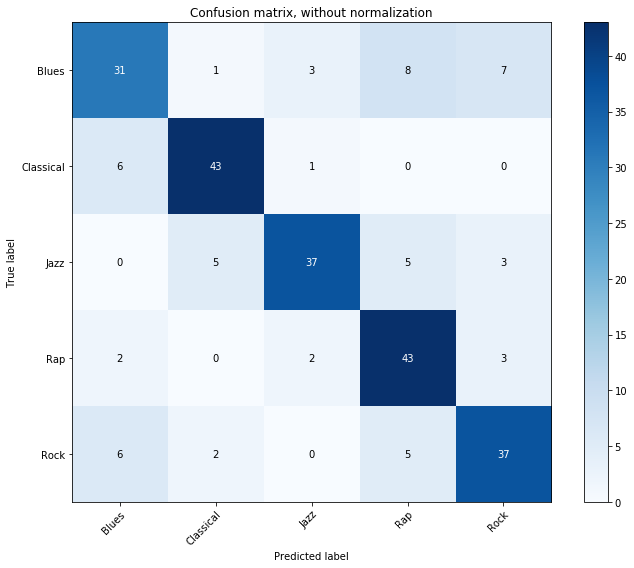

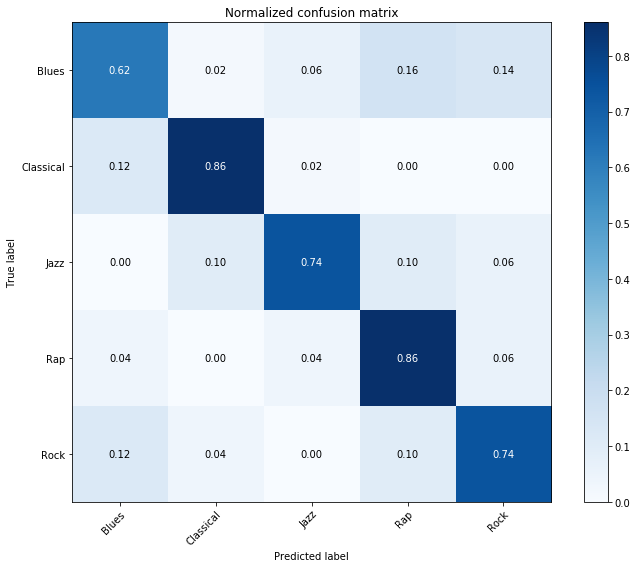

In [14]:
np.set_printoptions(precision=2)
plot_confusion_matrix(labels_1hot, predicted, classes=genres,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=genres, normalize=True,
                      title='Normalized confusion matrix')

### Experiment 2: Subgenres 

The experiment is the same, but applied to the 10 subgenre classes.

In [15]:
labels_1hot = onehot_labels(subgenres)
    
onehot2str(labels_1hot[0])

'Romantic'

In [16]:
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 10)

In [17]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [18]:
scores = cross_val_score(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

Epoch 1/100
225/225 [==============================] - 0s 1ms/sample - loss: 0.4372 - acc: 0.8222
Epoch 2/100
225/225 [==============================] - 0s 77us/sample - loss: 0.2676 - acc: 0.9084
Epoch 3/100
225/225 [==============================] - 0s 72us/sample - loss: 0.1871 - acc: 0.9213
Epoch 4/100
225/225 [==============================] - 0s 80us/sample - loss: 0.1278 - acc: 0.9458
Epoch 5/100
225/225 [==============================] - 0s 72us/sample - loss: 0.0931 - acc: 0.9627
Epoch 6/100
225/225 [==============================] - 0s 69us/sample - loss: 0.0630 - acc: 0.9778
Epoch 7/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0482 - acc: 0.9840
Epoch 8/100
225/225 [==============================] - 0s 69us/sample - loss: 0.0355 - acc: 0.9884
Epoch 9/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0400 - acc: 0.9884
Epoch 10/100
225/225 [==============================] - 0s 69us/sample - loss: 0.0252 - acc: 0.9938
Epoch 11/1

Epoch 81/100
225/225 [==============================] - 0s 74us/sample - loss: 5.1259e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 65us/sample - loss: 5.0029e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 72us/sample - loss: 4.8734e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 71us/sample - loss: 4.7494e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 72us/sample - loss: 4.6440e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 72us/sample - loss: 4.5504e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 66us/sample - loss: 4.4390e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 67us/sample - loss: 4.3213e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 69us/sample - loss: 4.2204e-05 - acc: 1.0000
Epoch 90/100
225/225 [==============================] - 0s 72us/

225/225 [==============================] - 0s 77us/sample - loss: 6.6928e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 67us/sample - loss: 6.4746e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 66us/sample - loss: 6.2939e-05 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 72us/sample - loss: 6.1258e-05 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 67us/sample - loss: 5.9545e-05 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 67us/sample - loss: 5.8040e-05 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 69us/sample - loss: 5.6448e-05 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 74us/sample - loss: 5.5044e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 73us/sample - loss: 5.3610e-05 - acc: 1.0000
Epoch 69/100
225/225 [==============================] - 0s 72us/sample - loss

225/225 [==============================] - 0s 65us/sample - loss: 0.0146 - acc: 0.9991
Epoch 40/100
225/225 [==============================] - 0s 73us/sample - loss: 0.0146 - acc: 0.9991
Epoch 41/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0146 - acc: 0.9991
Epoch 42/100
225/225 [==============================] - 0s 83us/sample - loss: 0.0145 - acc: 0.9991
Epoch 43/100
225/225 [==============================] - 0s 98us/sample - loss: 0.0145 - acc: 0.9991
Epoch 44/100
225/225 [==============================] - 0s 78us/sample - loss: 0.0145 - acc: 0.9991
Epoch 45/100
225/225 [==============================] - 0s 73us/sample - loss: 0.0145 - acc: 0.9991
Epoch 46/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0145 - acc: 0.9991
Epoch 47/100
225/225 [==============================] - 0s 78us/sample - loss: 0.0145 - acc: 0.9991
Epoch 48/100
225/225 [==============================] - 0s 79us/sample - loss: 0.0145 - acc: 0.9991
Epoch 49/100


225/225 [==============================] - 0s 67us/sample - loss: 0.0065 - acc: 0.9987
Epoch 21/100
225/225 [==============================] - 0s 63us/sample - loss: 0.0029 - acc: 0.9987
Epoch 22/100
225/225 [==============================] - 0s 63us/sample - loss: 0.0017 - acc: 1.0000
Epoch 23/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0022 - acc: 0.9991
Epoch 24/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0029 - acc: 0.9991
Epoch 25/100
225/225 [==============================] - 0s 61us/sample - loss: 0.0011 - acc: 1.0000
Epoch 26/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0030 - acc: 0.9991
Epoch 27/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0011 - acc: 1.0000
Epoch 28/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0022 - acc: 0.9991
Epoch 29/100
225/225 [==============================] - 0s 76us/sample - loss: 0.0017 - acc: 0.9991
Epoch 30/100


225/225 [==============================] - 0s 74us/sample - loss: 5.4107e-05 - acc: 1.0000
Epoch 100/100
25/25 [==============================] - 0s 9ms/sample - loss: 0.2951 - acc: 0.9560
Epoch 1/100
225/225 [==============================] - 0s 2ms/sample - loss: 0.4345 - acc: 0.8267
Epoch 2/100
225/225 [==============================] - 0s 70us/sample - loss: 0.2691 - acc: 0.9049
Epoch 3/100
225/225 [==============================] - 0s 71us/sample - loss: 0.2020 - acc: 0.9151
Epoch 4/100
225/225 [==============================] - 0s 72us/sample - loss: 0.1491 - acc: 0.9409
Epoch 5/100
225/225 [==============================] - 0s 74us/sample - loss: 0.1001 - acc: 0.9636
Epoch 6/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0679 - acc: 0.9787
Epoch 7/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0497 - acc: 0.9844
Epoch 8/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0311 - acc: 0.9916
Epoch 9/100
225/225 

225/225 [==============================] - 0s 73us/sample - loss: 7.2567e-05 - acc: 1.0000
Epoch 79/100
225/225 [==============================] - 0s 72us/sample - loss: 6.9181e-05 - acc: 1.0000
Epoch 80/100
225/225 [==============================] - 0s 75us/sample - loss: 6.8780e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 84us/sample - loss: 7.0778e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 73us/sample - loss: 6.9201e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 70us/sample - loss: 6.2917e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 71us/sample - loss: 6.2148e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 68us/sample - loss: 5.9387e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 65us/sample - loss: 5.7542e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 63us/sample - loss

225/225 [==============================] - 0s 89us/sample - loss: 9.9798e-04 - acc: 0.9996
Epoch 58/100
225/225 [==============================] - 0s 84us/sample - loss: 2.1366e-04 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 79us/sample - loss: 0.0032 - acc: 0.9991
Epoch 60/100
225/225 [==============================] - 0s 94us/sample - loss: 0.0036 - acc: 0.9991
Epoch 61/100
225/225 [==============================] - 0s 77us/sample - loss: 8.0997e-04 - acc: 0.9996
Epoch 62/100
225/225 [==============================] - 0s 81us/sample - loss: 0.0021 - acc: 0.9991
Epoch 63/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0011 - acc: 0.9991
Epoch 64/100
225/225 [==============================] - 0s 73us/sample - loss: 0.0024 - acc: 0.9991
Epoch 65/100
225/225 [==============================] - 0s 77us/sample - loss: 7.0778e-04 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 68us/sample - loss: 7.6111e-04 - acc: 

225/225 [==============================] - 0s 71us/sample - loss: 0.0015 - acc: 0.9991
Epoch 37/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0011 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 69us/sample - loss: 8.1710e-04 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 66us/sample - loss: 7.9916e-04 - acc: 1.0000
Epoch 40/100
225/225 [==============================] - 0s 71us/sample - loss: 7.2322e-04 - acc: 1.0000
Epoch 41/100
225/225 [==============================] - 0s 70us/sample - loss: 7.2151e-04 - acc: 1.0000
Epoch 42/100
225/225 [==============================] - 0s 70us/sample - loss: 8.6273e-04 - acc: 1.0000
Epoch 43/100
225/225 [==============================] - 0s 70us/sample - loss: 5.4957e-04 - acc: 1.0000
Epoch 44/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0010 - acc: 1.0000
Epoch 45/100
225/225 [==============================] - 0s 68us/sample - loss: 5.3956e-04

225/225 [==============================] - 0s 71us/sample - loss: 0.0054 - acc: 0.9982
Epoch 16/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0050 - acc: 0.9987
Epoch 17/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0041 - acc: 0.9991
Epoch 18/100
225/225 [==============================] - 0s 73us/sample - loss: 0.0030 - acc: 0.9987
Epoch 19/100
225/225 [==============================] - 0s 77us/sample - loss: 0.0025 - acc: 0.9991
Epoch 20/100
225/225 [==============================] - 0s 72us/sample - loss: 0.0081 - acc: 0.9973
Epoch 21/100
225/225 [==============================] - 0s 76us/sample - loss: 0.0061 - acc: 0.9978
Epoch 22/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0036 - acc: 0.9987
Epoch 23/100
225/225 [==============================] - 0s 67us/sample - loss: 0.0044 - acc: 0.9982
Epoch 24/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0033 - acc: 0.9982
Epoch 25/100


225/225 [==============================] - 0s 74us/sample - loss: 0.0144 - acc: 0.9991
Epoch 97/100
225/225 [==============================] - 0s 80us/sample - loss: 0.0144 - acc: 0.9991
Epoch 98/100
225/225 [==============================] - 0s 89us/sample - loss: 0.0144 - acc: 0.9991
Epoch 99/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0144 - acc: 0.9991
Epoch 100/100
25/25 [==============================] - 0s 11ms/sample - loss: 0.4429 - acc: 0.9120
Epoch 1/100
225/225 [==============================] - 0s 2ms/sample - loss: 0.4238 - acc: 0.8498
Epoch 2/100
225/225 [==============================] - 0s 80us/sample - loss: 0.2656 - acc: 0.9067
Epoch 3/100
225/225 [==============================] - 0s 77us/sample - loss: 0.1851 - acc: 0.9196
Epoch 4/100
225/225 [==============================] - 0s 77us/sample - loss: 0.1330 - acc: 0.9396
Epoch 5/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0969 - acc: 0.9578
Epoch 6/100
225/225 

225/225 [==============================] - 0s 79us/sample - loss: 3.5269e-04 - acc: 1.0000
Epoch 77/100
225/225 [==============================] - 0s 74us/sample - loss: 3.7086e-04 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 78us/sample - loss: 9.0979e-04 - acc: 0.9991
Epoch 79/100
225/225 [==============================] - 0s 73us/sample - loss: 0.0026 - acc: 0.9991
Epoch 80/100
225/225 [==============================] - 0s 86us/sample - loss: 2.7767e-04 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 76us/sample - loss: 4.6013e-04 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 75us/sample - loss: 5.4269e-04 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 74us/sample - loss: 3.3930e-04 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 78us/sample - loss: 3.2611e-04 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 78us/sample - loss: 4.

225/225 [==============================] - 0s 81us/sample - loss: 2.5874e-04 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 82us/sample - loss: 3.3747e-04 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 82us/sample - loss: 2.5876e-04 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 82us/sample - loss: 2.0145e-04 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 86us/sample - loss: 2.0877e-04 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 92us/sample - loss: 1.6960e-04 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 78us/sample - loss: 1.6908e-04 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 79us/sample - loss: 1.3943e-04 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 83us/sample - loss: 1.4172e-04 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 88us/sample - loss

array([0.93, 0.92, 0.9 , 0.96, 0.92, 0.92, 0.9 , 0.91, 0.92, 0.91])

In [19]:
np.mean(scores)

0.9195999920368194

In [20]:
predicted = cross_val_predict(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

Epoch 1/100
225/225 [==============================] - 0s 2ms/sample - loss: 0.3982 - acc: 0.8649
Epoch 2/100
225/225 [==============================] - 0s 73us/sample - loss: 0.2603 - acc: 0.9058
Epoch 3/100
225/225 [==============================] - 0s 72us/sample - loss: 0.1800 - acc: 0.9258
Epoch 4/100
225/225 [==============================] - 0s 70us/sample - loss: 0.1170 - acc: 0.9591
Epoch 5/100
225/225 [==============================] - 0s 85us/sample - loss: 0.0804 - acc: 0.9702
Epoch 6/100
225/225 [==============================] - 0s 85us/sample - loss: 0.0520 - acc: 0.9871
Epoch 7/100
225/225 [==============================] - 0s 82us/sample - loss: 0.0338 - acc: 0.9893
Epoch 8/100
225/225 [==============================] - 0s 83us/sample - loss: 0.0230 - acc: 0.9951
Epoch 9/100
225/225 [==============================] - 0s 90us/sample - loss: 0.0149 - acc: 0.9969
Epoch 10/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0082 - acc: 0.9996
Epoch 11/1

225/225 [==============================] - 0s 71us/sample - loss: 3.3935e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 73us/sample - loss: 3.3379e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 76us/sample - loss: 3.2595e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 71us/sample - loss: 3.1643e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 80us/sample - loss: 3.0787e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 97us/sample - loss: 3.0090e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 88us/sample - loss: 2.9286e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 95us/sample - loss: 2.8646e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 115us/sample - loss: 2.8061e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 86us/sample - los

225/225 [==============================] - 0s 74us/sample - loss: 5.1514e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 70us/sample - loss: 5.1511e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 70us/sample - loss: 4.8652e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 71us/sample - loss: 4.6639e-05 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 71us/sample - loss: 4.4673e-05 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 74us/sample - loss: 4.2062e-05 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 75us/sample - loss: 4.0783e-05 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 67us/sample - loss: 3.9603e-05 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 72us/sample - loss: 4.2042e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 68us/sample - loss

225/225 [==============================] - 0s 70us/sample - loss: 7.6398e-04 - acc: 1.0000
Epoch 40/100
225/225 [==============================] - 0s 73us/sample - loss: 6.8892e-04 - acc: 1.0000
Epoch 41/100
225/225 [==============================] - 0s 73us/sample - loss: 6.5035e-04 - acc: 1.0000
Epoch 42/100
225/225 [==============================] - 0s 70us/sample - loss: 6.2650e-04 - acc: 1.0000
Epoch 43/100
225/225 [==============================] - 0s 69us/sample - loss: 7.2413e-04 - acc: 1.0000
Epoch 44/100
225/225 [==============================] - 0s 73us/sample - loss: 4.2374e-04 - acc: 1.0000
Epoch 45/100
225/225 [==============================] - 0s 73us/sample - loss: 7.4120e-04 - acc: 1.0000
Epoch 46/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0012 - acc: 0.9991
Epoch 47/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0021 - acc: 0.9991
Epoch 48/100
225/225 [==============================] - 0s 73us/sample - loss: 0.0027

225/225 [==============================] - 0s 75us/sample - loss: 0.0035 - acc: 0.9987
Epoch 20/100
225/225 [==============================] - 0s 73us/sample - loss: 0.0030 - acc: 0.9991
Epoch 21/100
225/225 [==============================] - 0s 72us/sample - loss: 0.0023 - acc: 0.9991
Epoch 22/100
225/225 [==============================] - 0s 72us/sample - loss: 0.0020 - acc: 0.9991
Epoch 23/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0019 - acc: 0.9991
Epoch 24/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0017 - acc: 0.9996
Epoch 25/100
225/225 [==============================] - 0s 79us/sample - loss: 0.0024 - acc: 0.9991
Epoch 26/100
225/225 [==============================] - 0s 79us/sample - loss: 0.0014 - acc: 1.0000
Epoch 27/100
225/225 [==============================] - 0s 76us/sample - loss: 0.0028 - acc: 0.9991
Epoch 28/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0018 - acc: 0.9991
Epoch 29/100


225/225 [==============================] - 0s 2ms/sample - loss: 0.4518 - acc: 0.8173
Epoch 2/100
225/225 [==============================] - 0s 81us/sample - loss: 0.2631 - acc: 0.9027
Epoch 3/100
225/225 [==============================] - 0s 81us/sample - loss: 0.1805 - acc: 0.9209
Epoch 4/100
225/225 [==============================] - 0s 80us/sample - loss: 0.1312 - acc: 0.9502
Epoch 5/100
225/225 [==============================] - 0s 78us/sample - loss: 0.1037 - acc: 0.9600
Epoch 6/100
225/225 [==============================] - 0s 79us/sample - loss: 0.0768 - acc: 0.9716
Epoch 7/100
225/225 [==============================] - 0s 76us/sample - loss: 0.0734 - acc: 0.9800
Epoch 8/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0430 - acc: 0.9880
Epoch 9/100
225/225 [==============================] - 0s 76us/sample - loss: 0.0298 - acc: 0.9956
Epoch 10/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0188 - acc: 0.9964
Epoch 11/100
225/225 [

225/225 [==============================] - 0s 80us/sample - loss: 8.9230e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 90us/sample - loss: 8.5057e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 86us/sample - loss: 8.6516e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 103us/sample - loss: 7.8516e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 90us/sample - loss: 7.9559e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 87us/sample - loss: 7.8078e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 74us/sample - loss: 7.6416e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 72us/sample - loss: 7.1319e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 80us/sample - loss: 6.9141e-05 - acc: 1.0000
Epoch 90/100
225/225 [==============================] - 0s 79us/sample - los

225/225 [==============================] - 0s 76us/sample - loss: 1.1465e-04 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 73us/sample - loss: 1.1380e-04 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 84us/sample - loss: 1.0605e-04 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 75us/sample - loss: 1.0360e-04 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 85us/sample - loss: 1.0027e-04 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 83us/sample - loss: 1.0312e-04 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 89us/sample - loss: 9.3428e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 89us/sample - loss: 9.6105e-05 - acc: 1.0000
Epoch 69/100
225/225 [==============================] - 0s 83us/sample - loss: 8.5775e-05 - acc: 1.0000
Epoch 70/100
225/225 [==============================] - 0s 79us/sample - loss

225/225 [==============================] - 0s 87us/sample - loss: 0.0021 - acc: 0.9991
Epoch 42/100
225/225 [==============================] - 0s 80us/sample - loss: 7.5475e-04 - acc: 0.9996
Epoch 43/100
225/225 [==============================] - 0s 89us/sample - loss: 8.2987e-04 - acc: 0.9996
Epoch 44/100
225/225 [==============================] - 0s 82us/sample - loss: 9.2960e-04 - acc: 0.9996
Epoch 45/100
225/225 [==============================] - 0s 77us/sample - loss: 4.3338e-04 - acc: 1.0000
Epoch 46/100
225/225 [==============================] - 0s 85us/sample - loss: 6.4591e-04 - acc: 0.9996
Epoch 47/100
225/225 [==============================] - 0s 85us/sample - loss: 5.0209e-04 - acc: 1.0000
Epoch 48/100
225/225 [==============================] - 0s 85us/sample - loss: 2.9647e-04 - acc: 1.0000
Epoch 49/100
225/225 [==============================] - 0s 78us/sample - loss: 3.2189e-04 - acc: 1.0000
Epoch 50/100
225/225 [==============================] - 0s 88us/sample - loss: 2.

225/225 [==============================] - 0s 83us/sample - loss: 0.0026 - acc: 0.9991
Epoch 22/100
225/225 [==============================] - 0s 83us/sample - loss: 0.0014 - acc: 1.0000
Epoch 23/100
225/225 [==============================] - 0s 92us/sample - loss: 0.0017 - acc: 0.9991
Epoch 24/100
225/225 [==============================] - 0s 82us/sample - loss: 0.0032 - acc: 0.9991
Epoch 25/100
225/225 [==============================] - 0s 78us/sample - loss: 9.9595e-04 - acc: 1.0000
Epoch 26/100
225/225 [==============================] - 0s 86us/sample - loss: 0.0033 - acc: 0.9991
Epoch 27/100
225/225 [==============================] - 0s 84us/sample - loss: 0.0038 - acc: 0.9991
Epoch 28/100
225/225 [==============================] - 0s 90us/sample - loss: 0.0012 - acc: 1.0000
Epoch 29/100
225/225 [==============================] - 0s 79us/sample - loss: 0.0016 - acc: 0.9991
Epoch 30/100
225/225 [==============================] - 0s 86us/sample - loss: 0.0010 - acc: 1.0000
Epoch 31/

225/225 [==============================] - 0s 83us/sample - loss: 3.8038e-05 - acc: 1.0000
Epoch 1/100
225/225 [==============================] - 0s 2ms/sample - loss: 0.4364 - acc: 0.8289
Epoch 2/100
225/225 [==============================] - 0s 102us/sample - loss: 0.2691 - acc: 0.9076
Epoch 3/100
225/225 [==============================] - 0s 92us/sample - loss: 0.1871 - acc: 0.9191
Epoch 4/100
225/225 [==============================] - 0s 93us/sample - loss: 0.1201 - acc: 0.9582
Epoch 5/100
225/225 [==============================] - 0s 99us/sample - loss: 0.0802 - acc: 0.9711
Epoch 6/100
225/225 [==============================] - 0s 96us/sample - loss: 0.0577 - acc: 0.9818
Epoch 7/100
225/225 [==============================] - 0s 105us/sample - loss: 0.0458 - acc: 0.9840
Epoch 8/100
225/225 [==============================] - 0s 98us/sample - loss: 0.0301 - acc: 0.9907
Epoch 9/100
225/225 [==============================] - 0s 101us/sample - loss: 0.0181 - acc: 0.9960
Epoch 10/100
225

225/225 [==============================] - 0s 94us/sample - loss: 2.9446e-04 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 85us/sample - loss: 3.9095e-04 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 101us/sample - loss: 5.9469e-04 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 88us/sample - loss: 4.3509e-04 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 86us/sample - loss: 4.1211e-04 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 94us/sample - loss: 1.1728e-04 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 83us/sample - loss: 2.3871e-04 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 90us/sample - loss: 1.6878e-04 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 97us/sample - loss: 1.7258e-04 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 86us/sample - los

225/225 [==============================] - 0s 72us/sample - loss: 1.3437e-04 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 89us/sample - loss: 1.4112e-04 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 70us/sample - loss: 1.2561e-04 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 76us/sample - loss: 1.2988e-04 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 80us/sample - loss: 1.1637e-04 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 79us/sample - loss: 1.0100e-04 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 72us/sample - loss: 1.0333e-04 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 79us/sample - loss: 1.0584e-04 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 80us/sample - loss: 9.3640e-05 - acc: 1.0000
Epoch 69/100
225/225 [==============================] - 0s 80us/sample - loss

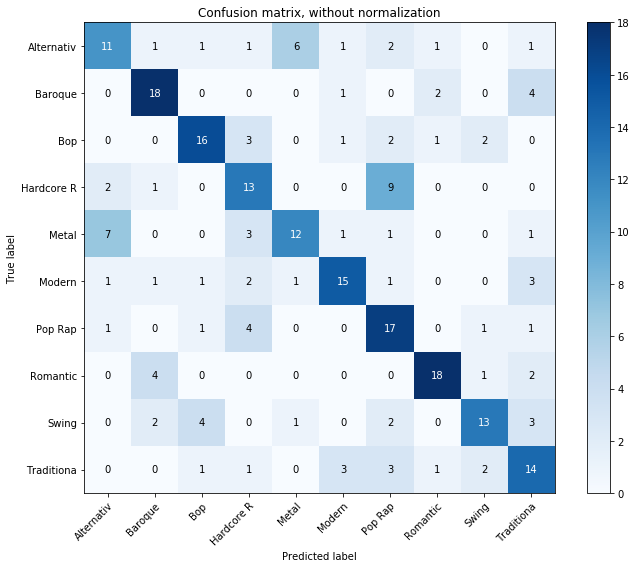

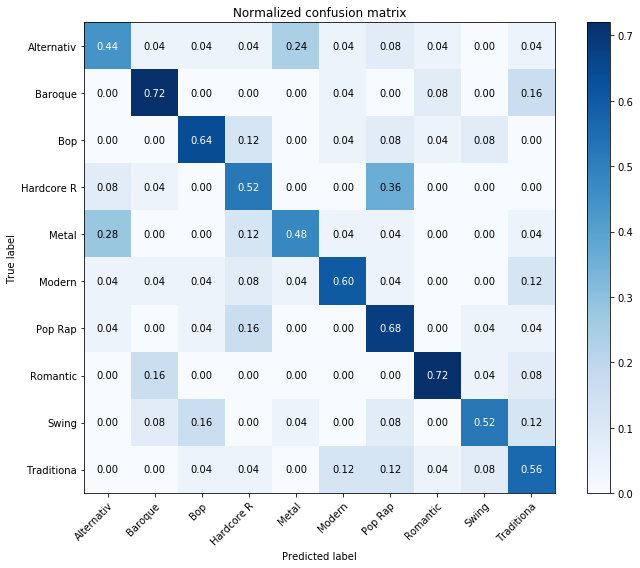

In [21]:
np.set_printoptions(precision=2)
plot_confusion_matrix(labels_1hot, predicted, classes=subgenres,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=subgenres, normalize=True,
                      title='Normalized confusion matrix')